In [8]:
import camb
import pywigxjpf as pywig
from joblib import Parallel, delayed
import sys, argparse, multiprocessing
#from common import *
from scipy.signal import savgol_filter

In [3]:
import numpy as np
import healpy as hp
import matplotlib
import matplotlib.pyplot as plt
import os

In [13]:
nside = 2560

In [14]:
print("  Creating pywig tables...")
NSIDE_MAX = 4096
pywig.wig_table_init(3*nside, 3)
pywig.wig_temp_init(3*nside)

  Creating pywig tables...


In [37]:
L_RECONST_MAX = 50

In [36]:
def GammakSZ(l1, l2, l, Cltd) :
  pref = np.sqrt((2.0*l1+1)*(2.0*l2+1)*(2.0*l+1)/4.0/np.pi)
  wig = pywig.wig3jj(2*l1, 2*l2, 2*l, 0, 0, 0) # 2*[j1,j2,j3,m1,m2,m3]
  return pref*wig*Cltd[l2]

def getNinv(l, ls, Cltd, ClTT, Cldd) :
  Ninv = 0.0
  if l < L_RECONST_MAX+1 :
    print("Working on l =", l)
    for l1 in ls: # TODO: don't include monopole, dipole contributions?
      for l2 in ls:
        Ninv += GammakSZ(l1, l2, l, Cltd)**2 / ClTT[l1] / Cldd[l2]
    Ninv /= (2.0*l + 1.0)
  else :
    Ninv = 1.0e50 # N = 1.0e-50
  return Ninv

In [4]:
h=0.69
pars = camb.CAMBparams()
pars.set_cosmology(H0=100.0*h, ombh2=0.048*h**2, omch2=0.262*h**2, mnu=0.06, omk=0)
pars.InitPower.set_params(As=2e-9, ns=0.96, r=0)
pars.set_for_lmax(6144, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='K')
l=np.arange(0,len(powers['total'][:,0]))
cambFactor = l*(l+1)/(2*np.pi)
CMB_camb = powers['total'][:,0]/cambFactor
CMB_camb[0]=0.0

#rho map is just the overdensity
def quadEst(ksz_map, rho_map):
    
    ksz_PS = hp.anafast(ksz_map)

    CMB_map = hp.sphtfunc.synfast(CMB_camb,nside=nside);
    
    Obs_T_map = ksz_map + CMB_map

    ClTT = hp.anafast(Obs_T_map)
    ClTT_filtered = np.concatenate(([1.0], savgol_filter(ClTT[1:], 51, 3)))
    
    dTlm = hp.map2alm(Obs_T_map)
    dlm = hp.map2alm(rho_map)

    dTlm_resc = hp.almxfl(dTlm, 1.0/ClTT)
    dT_resc = hp.alm2map(dTlm_resc, nside)
    dlm = -1.0*dlm # dlm_resc = hp.almxfl(dlm, 1.0) #Cltd/Cldd
    d_resc = hp.alm2map(dlm, nside)

    unnorm_veff_reconstlm = hp.map2alm(dT_resc*d_resc)
    unnorm_veff_reconst_ps = hp.alm2cl(unnorm_veff_reconstlm)
    unnorm_veff_reconst = hp.alm2map(unnorm_veff_reconstlm, nside)

    return unnorm_veff_reconst

<ipython-input-4-3cd4ecfd29d5>:10: RuntimeWarning: invalid value encountered in true_divide
  CMB_camb = powers['total'][:,0]/cambFactor


In [10]:
kSZ = np.load('./kSZ_NS_2560_R_2968_P_2048_DV_256_Sd_945986.npy')
overdensity = np.load('./overdensity_NS_2560_R_2968_P_2048_DV_256_Sd_945986.npy')
VelocityField = np.load('./VelocityField_NS_2560_R_2968_P_2048_DV_256_Sd_945986.npy')

In [15]:
reconVel = quadEst(kSZ,overdensity)

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


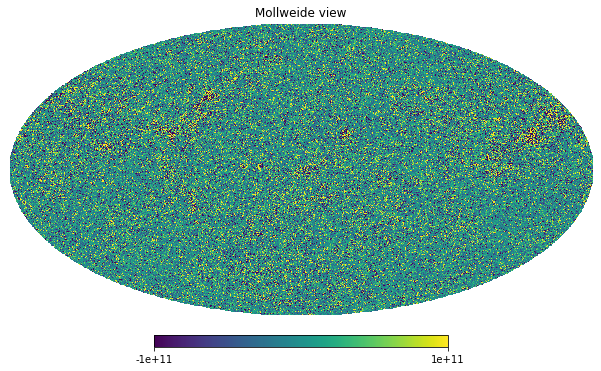

In [22]:
hp.mollview(reconVel,min=-10**11,max=10**11)

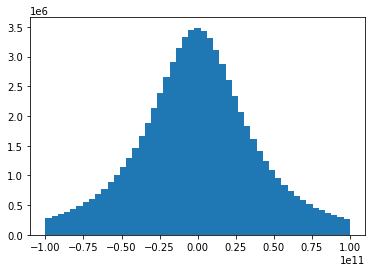

In [21]:
plt.hist(reconVel,bins=np.linspace(-10**11,10**11));

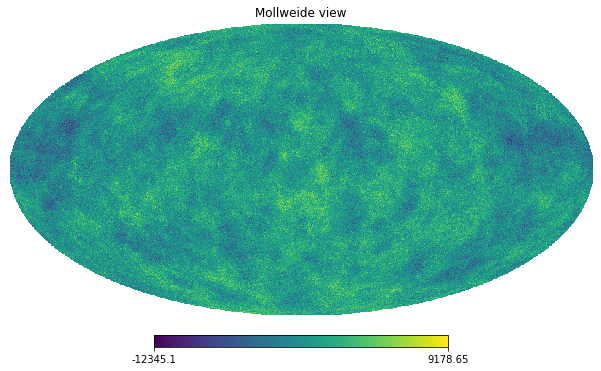

In [23]:
hp.mollview(VelocityField)

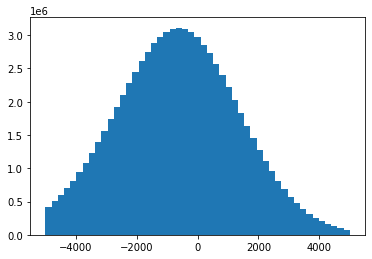

In [28]:
plt.hist(VelocityField,bins=np.linspace(-5*10**3,5*10**3));

In [40]:
smoothMap=hp.smoothing(reconVel,sigma=.02)

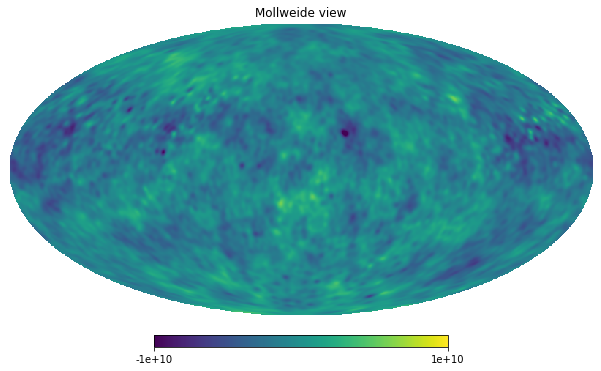

In [52]:
hp.mollview(smoothMap,min=-10**10,max=10**10)

In [42]:
def fun(x):
    return np.sum(np.abs(VelocityField-x*smoothMap))

In [44]:
from scipy import optimize

In [45]:
first_guess = 10**-8
res = optimize.minimize(fun, first_guess)

In [47]:
factor = res.x

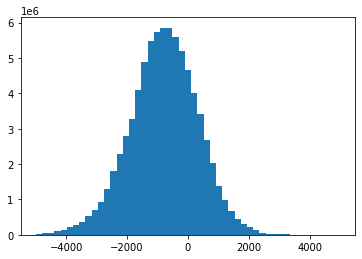

In [50]:
plt.hist(factor*smoothMap,bins=np.linspace(-5*10**3,5*10**3));

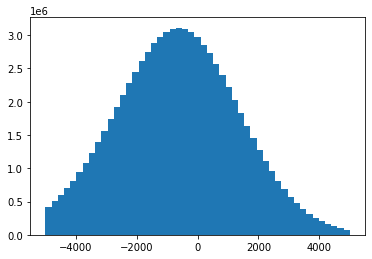

In [53]:
plt.hist(VelocityField,bins=np.linspace(-5*10**3,5*10**3));

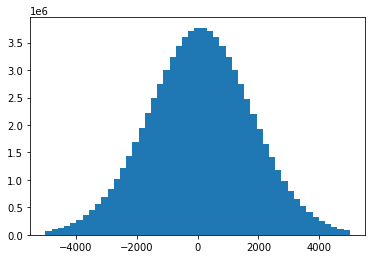

In [54]:
plt.hist(VelocityField-factor*smoothMap,bins=np.linspace(-5*10**3,5*10**3));

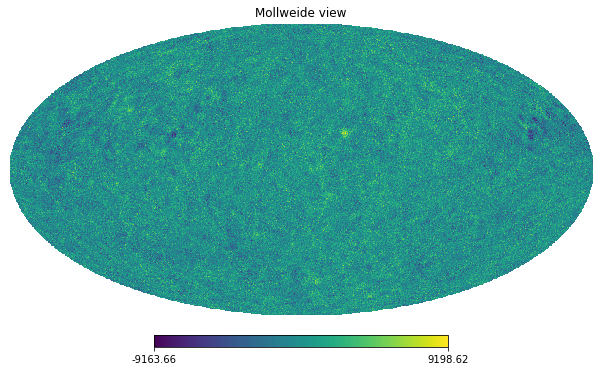

In [55]:
hp.mollview(VelocityField-factor*smoothMap)

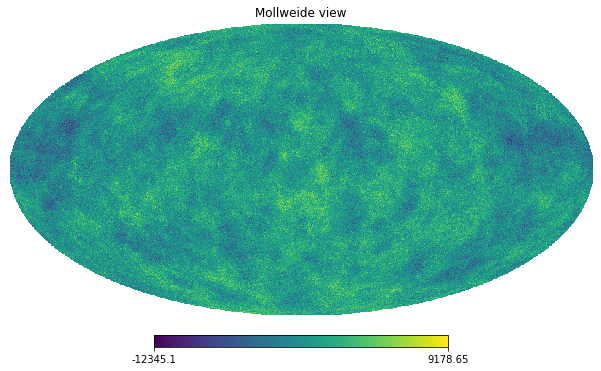

In [56]:
hp.mollview(VelocityField)